In [20]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

    
from types import ModuleType
from typing import Sequence, Tuple
import gymnasium as gym
# import gym

from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn

from EpisodeDataset import EpisodeDataset, ProcgenEpisodeDataset

import torch
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
  import matplotlib.pyplot as plt
import torch
import numpy as np

from typing import List

import visual_gridworld
from visual_gridworld.gridworld.minigrid_procgen import GridworldResizeObservation # absolute import




In [21]:

from scratchpads.EpisodeDataset import MultiEpisodeDataset



class LimitActions(gym.ActionWrapper):
    def __init__(self, env: gym.Env, actions: List[int]):
        assert isinstance(env.action_space, gym.spaces.Discrete) or isinstance(env.single_action_space, gym.spaces.Discrete)

        super().__init__(env)
        if hasattr(env, 'single_action_space'):
            self.single_action_space = gym.spaces.Discrete(len(actions))
            if len(env.action_space.shape) > 1:
                self.action_space = gym.spaces.MultiDiscrete((env.action_space.shape[0], ) * len(actions))
            else:
                self.action_space = gym.spaces.MultiDiscrete((len(actions), ))
        else:
            self.action_space = gym.spaces.Discrete(len(actions))

        self.action_indices = np.array(actions)

    def action(self, action):
        return self.action_indices[np.array(action)]
    
env_fn = lambda: LimitActions(GridworldResizeObservation(gym.make("Visual/DoorKey8x8-Gridworld-v0"), (84, 84)), [0, 1, 2, 3])
# train_data = ProcgenEpisodeDataset('procgen-coinrun-v0', wrapper=lambda x:  gym.wrappers.ResizeObservation(gym.wrappers.GrayScaleObservation(x), shape=(84,84)),
#             num_envs=1, max_steps=100, episodes_per_epoch=100, skip_first=10, repeat_action=1, device='cpu') 
train_data = MultiEpisodeDataset(env_fn, max_steps=200, episodes_per_epoch=100, skip_first=0, repeat_action=1, device='cpu')

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)


/home/jukebox/miniconda3/envs/cleanrl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (1, 240, 240, 3)
  logger.warn(
  0%|          | 0/100 [00:00<?, ?it/s]

/home/jukebox/miniconda3/envs/cleanrl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:257: UserWarning: WARN: Expects `terminated` signal to be a boolean, actual type: <class 'numpy.ndarray'>
  logger.warn(
/home/jukebox/miniconda3/envs/cleanrl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:261: UserWarning: WARN: Expects `truncated` signal to be a boolean, actual type: <class 'numpy.ndarray'>
  logger.warn(
/home/jukebox/miniconda3/envs/cleanrl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
100%|██████████| 100/100 [00:01<00:00, 54.19it/s]


In [22]:
for i in train_loader:
    print(i[0].shape)
    break

torch.Size([16, 84, 84, 3])


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit import ScriptModule, script_method, script
from torch import Tensor
from typing import Literal, Optional, Tuple, Union
from functools import partial



@script
def gaussian_fn(M: int, std: int) -> Tensor:
    n = torch.arange(0, M) - (M - 1.0) / 2.0
    sig2 = 2 * std * std
    w = torch.exp(-n ** 2 / sig2)
    return w

@script
def gkern(kernlen: int = 256, std: int = 128, vmin: float = 0, vmax: float = 1) -> Tensor:
    """Returns a 2D Gaussian kernel array."""
    gkern1d = gaussian_fn(kernlen, std=std) 
    gkern2d = torch.outer(gkern1d, gkern1d)
    return gkern2d * (vmax - vmin) + vmin


class Template(nn.Module):
    def __init__(self, M: int, out_size: int, var: torch.IntTensor, stride: int = 1,
                 cutoff: float = 0.2, initial_mixin_factor: float = 0.0,
                 device: torch.device = None):
        super().__init__()
        # Initialize basic parameters
        self.out_size = out_size  # Template size
        self.channels = M  # Number of channels

        # Mixin factor controls the interpolation between identity and templates
        self._mixin_factor = initial_mixin_factor
        self.cutoff = cutoff  # Cutoff threshold for template values
        self.device = device  # Device to run the model on (CPU/GPU)
        self.var = var  # Variance, can be a range or a fixed value
        self.stride = stride # Distance between mean of filters
        # Initially create templates based on the current variance
        self.create_new_templates(self._curr_var())

    @torch.jit.export
    def _curr_var(self, mixin: Optional[float] = None) -> int:
        # Determine the current variance based on the mixin factor
        # If `var` is a fixed int, just return it. If it's a tuple, interpolate.
        if mixin is None:
            return int(self.var[0] + self._mixin_factor * (self.var[1] - self.var[0]))
        return int(self.var[0] + mixin * (self.var[1] - self.var[0]))
    
    @torch.jit.export
    def set_mixin_factor(self, mixin_factor: float) -> None:
        # Update the mixin factor, ensuring it remains between 0 and 1
        _mixin_factor = max(0., min(1., mixin_factor))
        
        # If `var` is not a fixed value, recreate templates with the new variance
        if self._mixin_factor != _mixin_factor:
            self.create_new_templates(self._curr_var(_mixin_factor))
        self._mixin_factor = float(_mixin_factor)
        
    def create_new_templates(self, var: int) -> None:
        # Method to generate new templates based on given variance `var`
        
        n_square = (self.out_size * self.out_size)  # Total number of pixels
        tau = 0.5 / n_square  # Scaling factor for templates
        self.tau = tau
        alpha = n_square / (1 + n_square)  # Weight for positive template contribution
        beta = 4  # Scaling factor to amplify template values
        
        # Generate a base mask with Gaussian blur, cutoff, and scaling
        base = gkern(self.out_size*2-1, var, vmin=-self.cutoff, vmax=1.)[:,:,None]
        base = F.relu(base) * 2 - 1
        base = tau * torch.clamp(beta * base / self.out_size, min=-1)

        # Extract patches from the base mask to create templates
        templates = base.unfold(0, self.out_size, self.stride) \
                        .unfold(1, self.out_size, self.stride) \
                        .reshape(-1, self.out_size, self.out_size)
        templates = torch.flip(templates, dims=(0,))  # Correct orientation
        
        # Transfer templates to the specified device
        self.templates_f = templates.requires_grad_(False).to(self.device)
        neg_template = -tau * torch.ones(1, self.out_size, self.out_size)
        templates = torch.cat([templates, neg_template], 0)
        self.templates_b = templates.requires_grad_(False).to(self.device)

        # Probability distribution over templates
        p_T = [alpha / n_square for _ in range(self.templates_f.shape[0])]
        p_T.append(1 - alpha)  # Add probability for the negative template
        self.p_T = torch.FloatTensor(p_T).requires_grad_(False).to(self.device)
        

    def get_masked_output(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        # For each element in the batch, find the max pool index to select the corresponding template
        _, indices = F.max_pool2d(x, self.out_size, return_indices=True)
        indices = indices.view(x.shape[:2]).long()
        
        # Interpolate between the identity mask and the filtered templates based on mixin_factor
        # templates = torch.lerp(self.identity_mask, self.templates_f, self._mixin_factor)
        # Select templates for each index found by max pooling
        selected_templates = torch.stack([self.templates_f[(i/(self.stride**2)).long()] for i in indices], dim=0)
        # Apply the selected templates to the input and return the masked input and the templates
        x_masked = F.relu(x * selected_templates / selected_templates.max())
        return x_masked, selected_templates
    
    def compute_local_loss(self, x: Tensor) -> Tensor:  
        # Calculate the tensor dot product between input x and templates, then softmax to get probabilities
        tr_x_T = torch.einsum('bcwh,twh->cbt', x * self.tau, self.templates_b)
        p_x_T = F.softmax(tr_x_T, dim=1)
        # Calculate the adjusted probability distribution of x given T
        p_x = torch.einsum('t,cbt->cb', self.p_T, p_x_T)
        p_x = torch.log(p_x_T/p_x[:, :, None])
        # Calculate the log probability loss
        p_x_T_log = torch.einsum('cbt,cbt->ct', p_x_T, p_x)
        # Negative log likelihood loss
        loss = -torch.einsum('t,ct->c', self.p_T, p_x_T_log)
        return loss

    def forward(self, x: Tensor, train: bool = True) -> Union[Tuple[Tensor, Tensor, Tensor], Tuple[Tensor, Tensor]]:
        # Main forward pass
        x, obs_mask = self.get_masked_output(x)  # Get masked output based on the current mixin_factor
        if train:
            # If training, also compute the local loss
            loss_1 = self.compute_local_loss(x)
            return x, obs_mask, loss_1  # Return the masked input and the computed loss
        return x, obs_mask # For inference, just return the masked input

    
class SqueezeAggregateLayer(nn.Module):
    def __init__(self, input_channels, output_channels, aggregate: Literal['sum', 'mean'] = 'sum'):
        """
        Initialize the layer.
        
        Parameters:
        - num_channels: The number of channels in the input tensor.
        - K: The number of groups to divide the channels into.
        - template_size: The size of the template to reshape the spatial dimensions.
        """
        super(SqueezeAggregateLayer, self).__init__()
        self.num_channels = input_channels
        self.K = output_channels

        if aggregate == 'sum':
            self.aggregate = partial(torch.sum, dim=1)
        elif aggregate == 'mean':
            self.aggregate = partial(torch.mean, dim=1)

        if input_channels % output_channels != 0:
            raise ValueError("num_channels must be divisible by K")

    def forward(self, x):
        """
        Forward pass of the layer.
        
        Parameters:
        - x: Input tensor of shape (N, C, H, W) where
             N is the batch size,
             C is the number of channels (should match num_channels),
             H and W are the height and width of the input.
             
        Returns:
        - Output tensor after reshaping and summing.
        """
        N, C, H, W = x.shape
        if C != self.num_channels:
            raise ValueError(f"Input tensor has {C} channels, expected {self.num_channels}")
        
        # Reshape the input tensor and sum across the specified dimension
        x = x.view(N, -1, self.K, H, W)
        x = self.aggregate(x)

        return x

class ActionPredictor(nn.Module):    
    def __init__(self, 
                 input_dim: Sequence[int],
                 input_channels: int,
                 action_dim: int,
                 cutoff: float = 0.2,
                 template_var: List[float] = [36, 12],
                 n_templates: int = 1,

                 device = None):
        super().__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim

        self.preprocess = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=8, padding=4),
            nn.ReLU(),
            SqueezeAggregateLayer(16, n_templates, aggregate='sum')
        )

        with torch.no_grad():
            self.template_size = self.preprocess(torch.rand((1, *input_dim))).shape[-1]
        self.template_counts = n_templates
        self.template = torch.jit.script(Template(M=n_templates, cutoff=cutoff, out_size=self.template_size, var=template_var, stride=4, device=device))
        
        self.backbone = nn.Sequential(
            nn.Conv2d(n_templates, 16, kernel_size=8, stride=4, padding=4),
            nn.SiLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=2),
            nn.SiLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=2),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Flatten()
        )


        with torch.no_grad():
            self.cnn_output_size = self.backbone(torch.rand((1, n_templates, self.template_size, self.template_size))).shape[-1]

        self.mlp = nn.Sequential(
            nn.Linear(self.cnn_output_size, 128),
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, self.action_dim),
            nn.Softmax()
        )
                
        self.preprocess.to(device)
        self.backbone.to(device)
        self.mlp.to(device)
        
    def _forward_prong(self, x, mask, train):
        B = S = C = H = W = -1
        if len(x.shape) == 5:
            B, S, C, H, W = x.shape
            x = x.view((-1, C, H, W))
            x.shape 
        else:
            B, C, H, W = x.shape
        x = x.reshape(-1, *self.input_dim)
        x = self.preprocess(x)

        local_loss = 0
        obs_mask = None
        if mask:
            x, obs_mask, local_loss = self.template(x, train=train)

            obs_mask = obs_mask.sum(dim=1, keepdim=True)
            obs_mask = F.upsample_nearest(obs_mask, (H, W)).view(B, 1, H, W)

        return self.backbone(x), obs_mask, local_loss
        
    def forward(self, x1, x2, mask=True, train=True):
        B = S = C = H = W = -1
        if len(x1.shape) == 5:
            B, S, C, H, W = x1.shape
            x1 = x1.view((-1, C, H, W))
            x2 = x2.view((-1, C, H, W))
        else:
            B, C, H, W = x1.shape

        x1, obs_mask1, local_loss1 = self._forward_prong(x1, mask, train)
        x2, obs_mask2, local_loss2 = self._forward_prong(x2, mask, train)
        
        x = x1 - x2
        local_loss = local_loss1 + local_loss2

        x = self.mlp(x)

        if len(x.shape) == 5:
            x = x.view((B, S) + self.action_dim)
        else:
            x = x.view((B, self.action_dim))
        return (x, obs_mask1, obs_mask2, local_loss) if mask and train else (x, obs_mask1, obs_mask2)
    

    def get_mask(self, x):
        B = S = C = H = W = -1
        if len(x1.shape) == 5:
            B, S, C, H, W = x1.shape
            x1 = x1.view((-1, C, H, W))
            x2 = x2.view((-1, C, H, W))
        else:
            B, C, H, W = x1.shape
        x = self.preprocess(x)
        x, obs_mask = self.template.get_masked_output(x)
        obs_mask = obs_mask.sum(dim=1, keepdim=True)
        obs_mask = F.interpolate(obs_mask, (H, W), mode='bilinear').view(B, 1, H, W)


        selected_templates -= selected_templates.min()[0]
        selected_templates /= selected_templates.max()[0]

        return selected_templates
    


def preprocess(x: Tensor) -> Tensor:
    x = x / 255.
    # x = x.unsqueeze(1)
    x = x.movedim(-1, 1)
    return x

def evaluate(net):
    preds = []
    y = []
    for i, data in enumerate(train_loader):

            # get the inputs; data is a list of [inputs, labels]
            state, action, reward, done, next_state = data
            # forward + backward + optimize
            state = preprocess(state)
            next_state = preprocess(next_state)

            outputs = net(state, next_state)[0]
            outputs = outputs.cpu().detach().numpy()
            action = action.cpu().detach().numpy()


            preds.extend(outputs)
            y.extend(action)

    preds = np.stack(preds, axis=0).argmax(axis=-1)
    y = np.stack(y, axis=0).argmax(axis=-1)
    print(y.shape, preds.shape)
    print(classification_report(y, preds))

In [24]:
from tqdm.notebook import tqdm
from torchmetrics.functional.classification import multiclass_accuracy

obs_space = env_fn().single_observation_space
action_n = env_fn().single_action_space.n
"""

                 input_dim: Sequence[int],
                 action_dim: int,
                 stages: Sequence[int],
                 backbone_stages: Sequence[int],
                 dense_units: Sequence[int],
                 template_var: Union[int, Iterable[int]], 
                 templates: int, 
                 activation: ModuleType = nn.SiLU,
                 layer_norm: bool = False,
                 device=None):
"""
print(obs_space)
"""
self, M: int, out_size: int, var: torch.IntTensor, stride: int = 1,
                 cutoff: float = 0.2, initial_mixin_factor: float = 0.0,
                 device: torch.device = None
"""
net = ActionPredictor(input_dim=(3, 84, 84),
                      input_channels=3,
                      action_dim=action_n, 
                      cutoff=0.2,
                      template_var=[70, 15],
                      )
net.template.set_mixin_factor(1.0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0001)
mask = False
mask_at_epoch = 5
mask_stop_at = 15
max_acc = 0
count = 0

evaluate(net)
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        state, action, reward, done, next_state = data

        state = preprocess(state)
        next_state = preprocess(next_state)
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = net.train_interpretable_step(state, next_state)
        if mask:
            outputs, _, _, local_loss = net(state, next_state, mask)
            loss = local_loss.sum()
        else:
            outputs, _, _ = net(state, next_state, mask)
            loss = 0

        loss += criterion(outputs, action)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_accuracy += multiclass_accuracy(outputs.argmax(dim=-1), action.argmax(dim=-1), num_classes=int(action_n))
        
        
    if epoch >= mask_at_epoch:
        mask = True
    net.template.set_mixin_factor((epoch - mask_at_epoch) * (1/(mask_stop_at - mask_at_epoch)))
    _max_acc = running_accuracy / len(train_loader)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_loader):.3f} acc: {_max_acc:.3f}')

    # if _max_acc > max_acc or epoch < 15:
    #     max_acc = _max_acc
    # else:
    #     count += 1
    
    # if count > 5:
    #     break

    running_accuracy = 0.0
    running_loss = 0.0
    
evaluate(net)

Box(0, 255, (1, 84, 84, 3), uint8)
(20000,) (20000,)
              precision    recall  f1-score   support

           0       0.26      1.00      0.41      5116
           1       0.00      0.00      0.00      4948
           2       0.00      0.00      0.00      5004
           3       0.00      0.00      0.00      4932

    accuracy                           0.26     20000
   macro avg       0.06      0.25      0.10     20000
weighted avg       0.07      0.26      0.10     20000



/home/jukebox/miniconda3/envs/cleanrl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jukebox/miniconda3/envs/cleanrl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jukebox/miniconda3/envs/cleanrl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

  0%|          | 0/1250 [00:00<?, ?it/s]

/home/jukebox/miniconda3/envs/cleanrl/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1,  1250] loss: 1.338 acc: 0.355


  0%|          | 0/1250 [00:00<?, ?it/s]

[2,  1250] loss: 1.112 acc: 0.659


  0%|          | 0/1250 [00:00<?, ?it/s]

[3,  1250] loss: 0.994 acc: 0.760


  0%|          | 0/1250 [00:00<?, ?it/s]

[4,  1250] loss: 0.939 acc: 0.812


  0%|          | 0/1250 [00:00<?, ?it/s]

KeyboardInterrupt: 

torch.Size([16, 1, 85, 85])
tensor(0.) tensor(3.2492e-06) tensor(False)
tensor(False)
tensor(0.) tensor(1.)


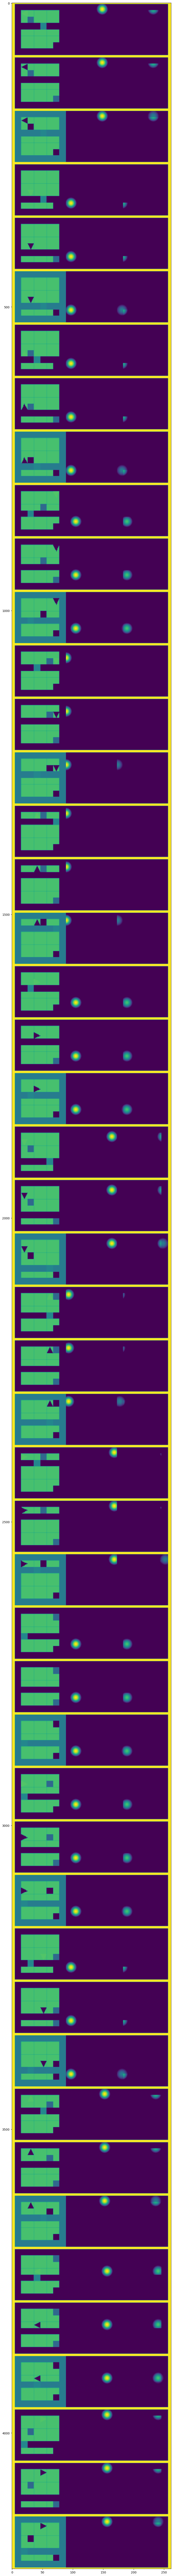

In [ ]:
def norm(tensor):
    tensor -= tensor.min()
    
    tensor /= tensor.max()
    return tensor


net.template.set_mixin_factor(0.7)

state, action, reward, done, next_state = next(train_loader.__iter__())

state = preprocess(state)

z = net.preprocess(state)
print(z.shape)
# z = z.view(-1, 42, 1, 9, 9).sum(1)
_, template = net.template.get_masked_output(z)
template = F.relu(template)
upscaled_template = F.interpolate(template, (84, 84), mode='bilinear')
print(upscaled_template.min(), upscaled_template.max(), upscaled_template.isnan().any())

avg_filter = upscaled_template.mean(dim=1)
print(avg_filter.isnan().any())
avg_filter = norm(avg_filter)
print(avg_filter.min(), avg_filter.max())
avg_filter = avg_filter.unsqueeze(dim=1).repeat(1, 3, 1, 1)

# print(template.min(),template.max())
# fig, ax = plt.subplots(figsize=(16, 120))
# template = template.view(-1, template.shape[-1])
# ax.imshow(template)
# plt.tight_layout()

states = state.detach().cpu()
states = states
# states = F.pad(states, (5, 5, 5, 5), mode='constant', value=0)
# avg_filter = F.pad(avg_filter, (5, 5, 5, 5), mode='constant', value=0)

img = torch.concat([states, avg_filter, states * avg_filter], dim=-1)
img = F.pad(img, (5, 5, 2, 2), mode='constant', value=1)
img = img.view(-1, img.shape[-1])

fig, ax = plt.subplots(figsize=(16, 120))
ax.imshow(img)
plt.tight_layout()



70
___0
___1
63
___2
57
___3
51
___4
45
___5
39
___6
33
___7
27
___8
21
___9
15
___10
9


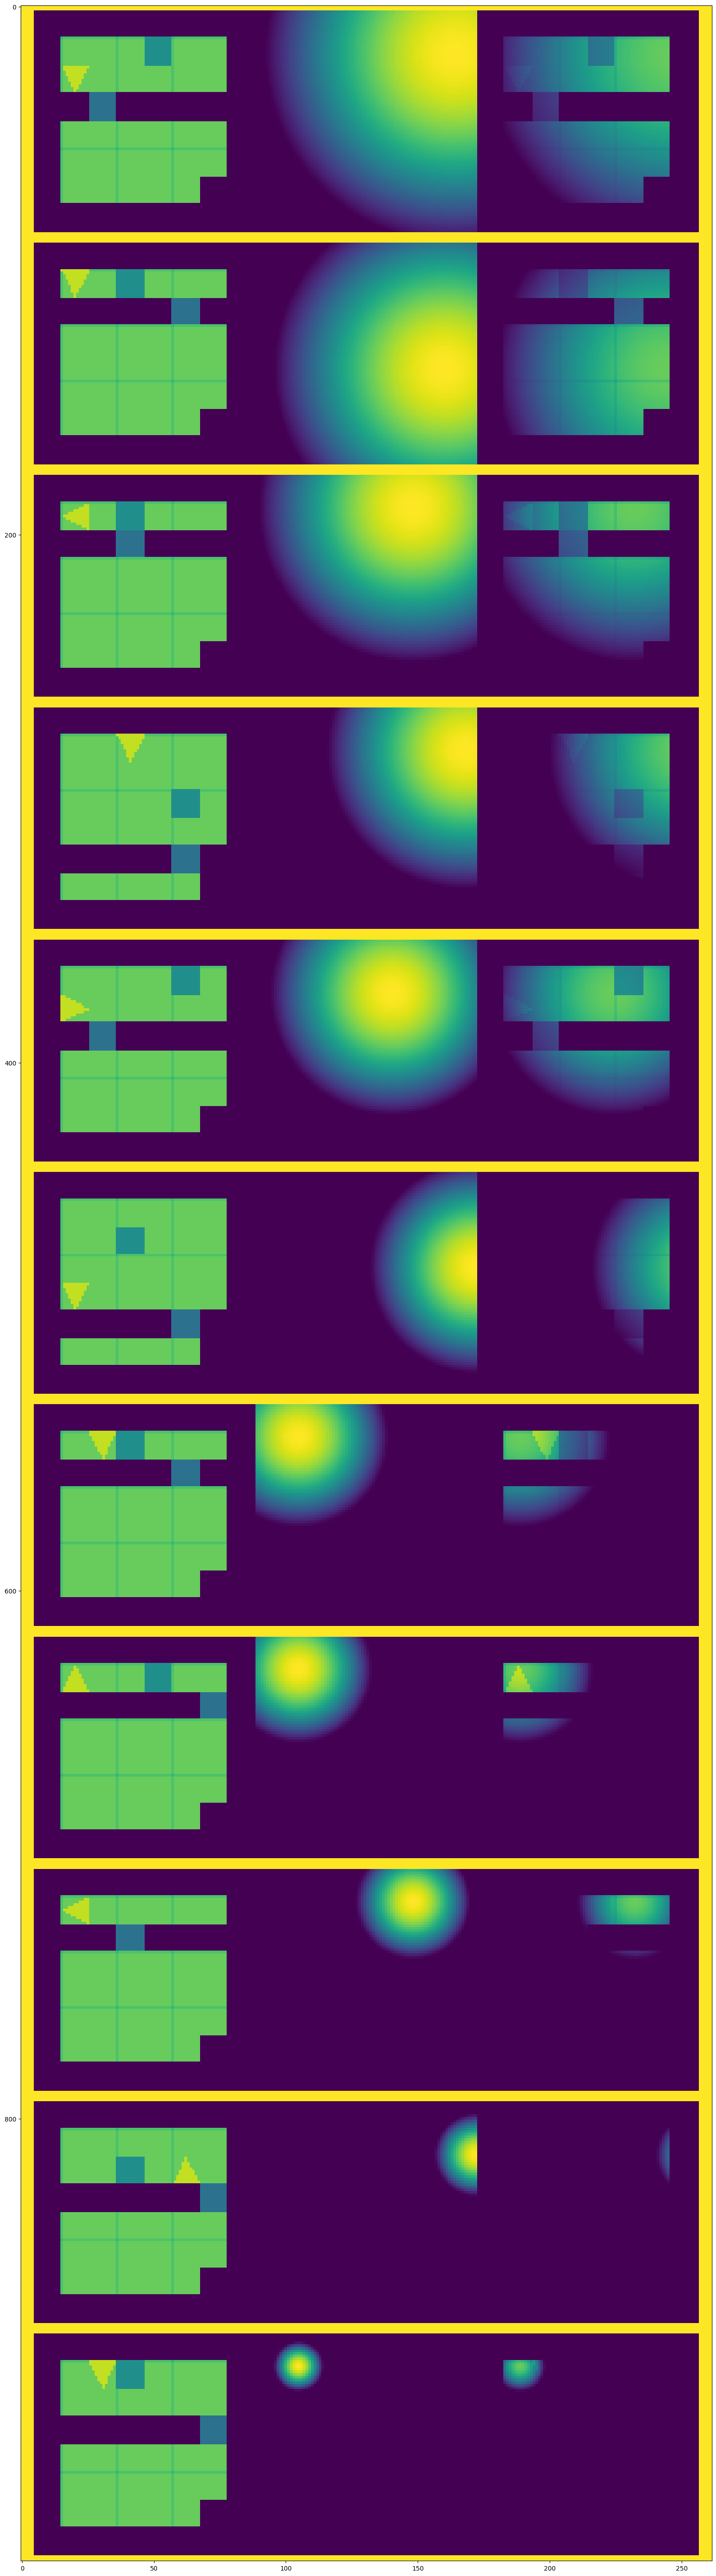

In [ ]:
def norm(tensor):
    tensor -= tensor.min()
    
    tensor /= tensor.max()
    return tensor


net = ActionPredictor(input_dim=(3, 84, 84),
                      input_channels=3,
                      action_dim=4, 
                      cutoff=0.2,
                      template_var=[70, 9],
                      )
s = []
for i in range(11):
    print('___' + str(i))
    net.template.set_mixin_factor(i * (1/10))

    state, action, reward, done, next_state = next(train_loader.__iter__())

    state = preprocess(state)

    z = net.preprocess(state)
    # z = z.view(-1, 42, 1, 9, 9).sum(1)
    _, template = net.template.get_masked_output(z)
    template = F.relu(template)
    upscaled_template = F.interpolate(template, (84, 84), mode='bilinear')

    avg_filter = upscaled_template.mean(dim=1)
    avg_filter = norm(avg_filter)
    avg_filter = avg_filter.unsqueeze(dim=1).repeat(1, 3, 1, 1)

    # print(template.min(),template.max())
    # fig, ax = plt.subplots(figsize=(16, 120))
    # template = template.view(-1, template.shape[-1])
    # ax.imshow(template)
    # plt.tight_layout()

    states = state.detach().cpu()
    states = states
    img = torch.concat([states, avg_filter, states * avg_filter], dim=-1)[0][0]
    img = F.pad(img, (5, 5, 2, 2), mode='constant', value=1)
    img = img.view(-1, img.shape[-1])
    s.append(img)

# states = F.pad(states, (5, 5, 5, 5), mode='constant', value=0)
# avg_filter = F.pad(avg_filter, (5, 5, 5, 5), mode='constant', value=0)

img = torch.concat(s, dim=0)
fig, ax = plt.subplots(figsize=(16, 120))
ax.imshow(img)
plt.tight_layout()

